# Imports

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import librosa
import librosa.display
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random

# Helper Functions

## Set Device

In [6]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

## Set Seed

In [7]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


In [9]:
DATASET_PATH = "/kaggle/input/noisy-audio-mnist"
SPEAKER_IDS = [f"0{id}" if id < 10 else f"{id}" for id in range(1, 61)]

# Organize the Data in a `DataFrame`

In [10]:
data = []
for speaker_id in SPEAKER_IDS:
    current_speaker_path = os.path.join(DATASET_PATH, speaker_id)
    for _, _, filenames in os.walk(current_speaker_path):
        for filename in filenames:
            if "noisy" not in filename:  # Check for clean files
                # Extract the digit and speaker ID from the filename
                name_parts = filename.split("_")
                digit = name_parts[0]
                # Create the output (noisy) file name
                input_file_name = filename.replace(".wav", "_noisy.wav")
                #Check if the output file exists
                if input_file_name not in filenames:
                    print(f"{filename} does not have a noisy version!")
                    continue
                # Append to the list
                data.append({
                    "input_file_name": input_file_name,
                    "output_file_name": filename,
                    "digit": digit,
                    "speaker_id": speaker_id
                })

In [11]:
df = pd.DataFrame(data)

In [12]:
df.head()

,input_file_name,output_file_name,digit,speaker_id
0,6_01_49_noisy.wav,6_01_49.wav,6,01
1,1_01_26_noisy.wav,1_01_26.wav,1,01
2,3_01_32_noisy.wav,3_01_32.wav,3,01
3,3_01_12_noisy.wav,3_01_12.wav,3,01
4,4_01_17_noisy.wav,4_01_17.wav,4,01


# EDA

## Select a row from `df` to visualize the pre processing steps

In [25]:
example_recorde = df.iloc[3867]
example_recorde

input_file_name     1_08_20_noisy.wav
output_file_name          1_08_20.wav
digit                               1
speaker_id                         08
Name: 3867, dtype: object

In [26]:
dir_path = os.path.join(DATASET_PATH, example_recorde["speaker_id"])
file_path = os.path.join(dir_path, example_recorde["output_file_name"])
noisy_path = os.path.join(dir_path, example_recorde["input_file_name"])
print(f"Sampling Rate :  {librosa.get_samplerate(file_path)} Hz")
print(f"Duration : {librosa.get_duration(path=file_path)} s")

Sampling Rate :  48000 Hz
Duration : 0.5519166666666667 s


## Visualize audio as a waveform

In [27]:
SR = 48000
signal, sr_read = librosa.load(file_path, sr=SR)
noisy_signal, sr_read_noisy = librosa.load(noisy_path, sr=SR)

## Create Spectrogram of the Audio

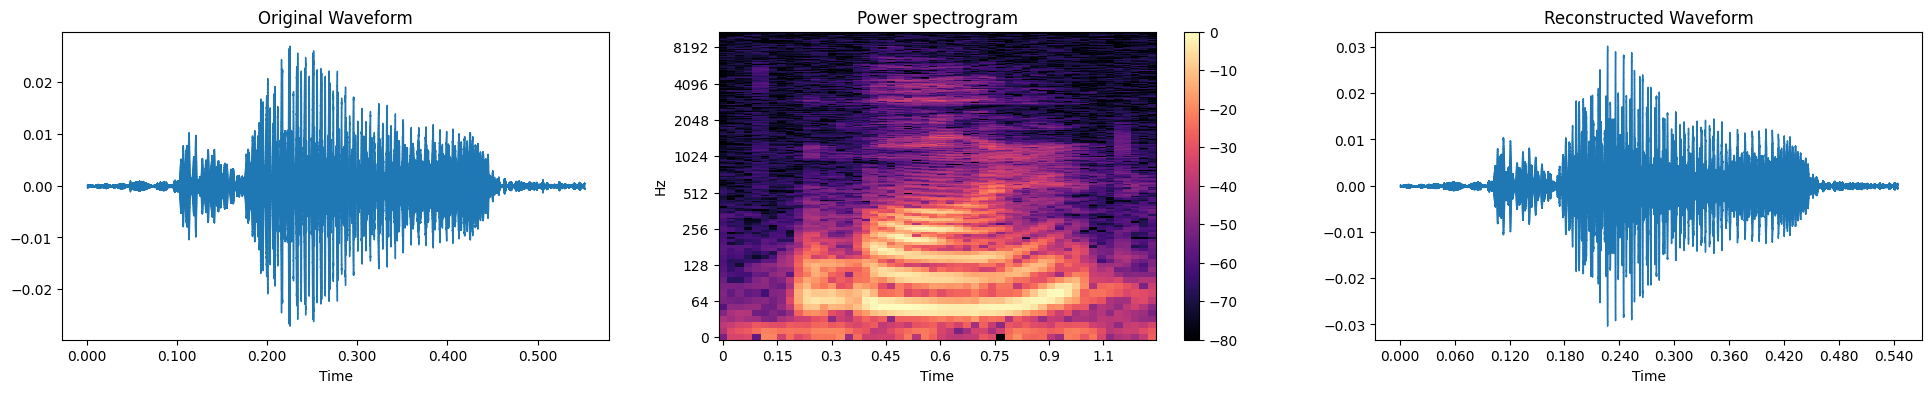

In [28]:
n_fft = 2048
hop_length = 512
ft = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length = hop_length))
ft_inv = librosa.griffinlim(ft)
fig, ax = plt.subplots(ncols=3, figsize = (24,4))
# Plot original waveform:
librosa.display.waveshow(signal, sr=SR, ax=ax[0])
ax[0].set_title('Original Waveform')
# Plot power spectrogram:
img = librosa.display.specshow(librosa.amplitude_to_db(ft, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Power spectrogram')
fig.colorbar(img, ax=ax[1])
# Plot reconstructed waveform
librosa.display.waveshow(ft_inv, sr=SR, ax=ax[2])
ax[2].set_title('Reconstructed Waveform')

plt.show()

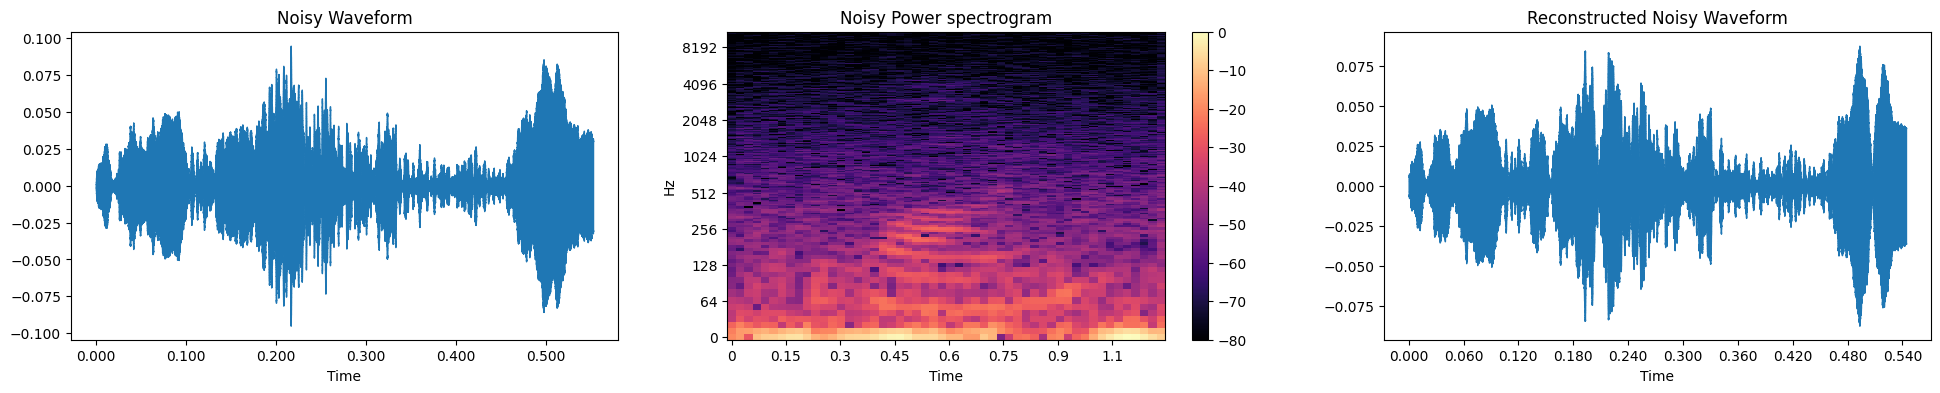

In [29]:
noisy_ft = np.abs(librosa.stft(noisy_signal, n_fft=n_fft, hop_length = hop_length))
noisy_ft_inv = librosa.griffinlim(noisy_ft)
fig, ax = plt.subplots(ncols=3, figsize = (24,4))
# Plot original waveform:
librosa.display.waveshow(noisy_signal, sr=SR, ax=ax[0])
ax[0].set_title('Noisy Waveform')
# Plot power spectrogram:
img = librosa.display.specshow(librosa.amplitude_to_db(noisy_ft, ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Noisy Power spectrogram')
fig.colorbar(img, ax=ax[1])
# Plot reconstructed waveform
librosa.display.waveshow(noisy_ft_inv, sr=SR, ax=ax[2])
ax[2].set_title('Reconstructed Noisy Waveform')

plt.show()

## Mel-Spectrogram

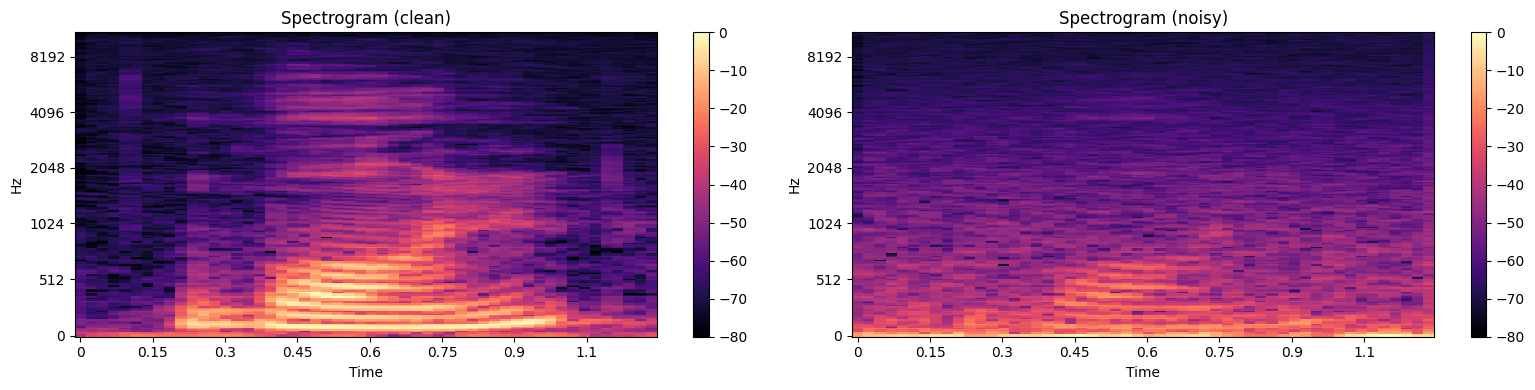

In [30]:
n_mels = 256
mel_ft = librosa.feature.melspectrogram(y=signal, sr=SR, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
noisy_mel_ft = librosa.feature.melspectrogram(y=noisy_signal, sr=SR, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Prepare plot:
fig, ax = plt.subplots(ncols=2, figsize = (16,4))

# Clean Mel spectrogram:
img1 = librosa.display.specshow(librosa.power_to_db(mel_ft, ref=np.max), 
                                 y_axis='mel', x_axis='time', ax=ax[0])
ax[0].set_title('Spectrogram (clean)')
fig.colorbar(img1, ax=ax[0])

# Noisy Mel spectrogram
img2 = librosa.display.specshow(librosa.power_to_db(noisy_mel_ft, ref=np.max), 
                                 y_axis='mel', x_axis='time', ax=ax[1])
ax[1].set_title('Spectrogram (noisy)')
fig.colorbar(img2, ax=ax[1])

plt.tight_layout()
plt.show()

In [31]:
n_fft = 2048
hop_length = 512
mel_spec = librosa.power_to_db(librosa.feature.melspectrogram(y=signal, sr=SR, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels))
original_shape = mel_spec.shape
print(f"Shape of Mel-Spectrogram: {original_shape}")

Shape of Mel-Spectrogram: (256, 52)


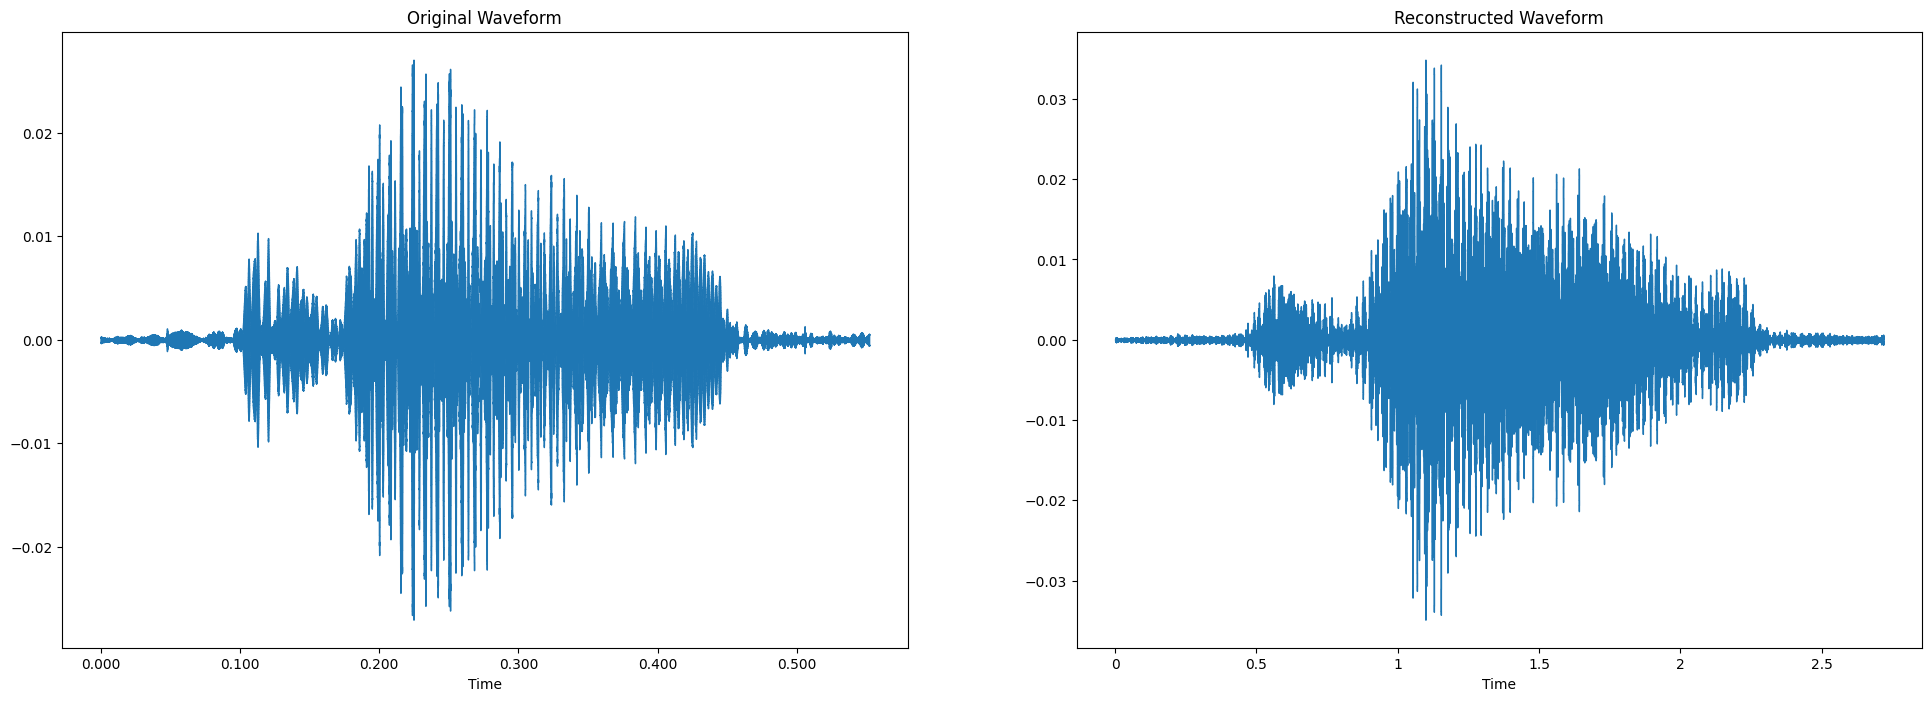

In [32]:
target_shape = (112, 112)
resize_mel_spec = cv2.resize(mel_spec, target_shape, interpolation=cv2.INTER_AREA)
recons_mel_spec = cv2.resize(resize_mel_spec, original_shape, interpolation=cv2.INTER_AREA)
power_recons_mel_spec = librosa.db_to_power(recons_mel_spec)
reconstructed_signal = librosa.feature.inverse.mel_to_audio(power_recons_mel_spec, 
                                                            sr=SR, 
                                                            n_fft=n_fft, 
                                                            hop_length=hop_length)
fig, ax = plt.subplots(ncols=2, figsize = (24,8))
# Plot original waveform:
librosa.display.waveshow(signal, sr=SR, ax=ax[0])
ax[0].set_title('Original Waveform')
# Plot reconstructed waveform
librosa.display.waveshow(reconstructed_signal, sr=SR, ax=ax[1])
ax[1].set_title('Reconstructed Waveform')
plt.show()

# Define `Dataset` and `Dataloader`

In [33]:
class CustomDataset(Dataset):
    """
    Custom dataset for loading audio data from a dataframe
    """
    
    
    def __init__(self, df: pd.DataFrame, sample_rate: int, size: int, 
                 N_fft: int, hop_length: int, n_mels: int):
        """
        Args:
            df(DataFrame); dataframe containing file names
        """
        self.df = df
        self.size = size
        self.sample_rate = sample_rate
        self.N_fft = N_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        
        
    def __len__(self):
        return len(self.df)


    def get_input_output_files_path(self, idx: int):
        input_name = self.df.iloc[idx]['input_file_name']
        output_name = self.df.iloc[idx]['output_file_name']
        speaker_id = self.df.iloc[idx]['speaker_id']
        #print(f"input name is: {input_name}")
        #print(f"output name is: {output_name}")
        # Create directory name
        dirname = os.path.join(DATASET_PATH, speaker_id)
        # Combine directory with file name
        input_path = os.path.join(dirname, input_name)
        output_path = os.path.join(dirname, output_name)
        return input_path, output_path

    


    def get_mel_spectrogram(self, signal):
        """
        Create Mel Spectrogram of the signal and perform preprocessing.
        """
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=self.sample_rate, 
                                                  n_fft=self.N_fft, 
                                                  hop_length=self.hop_length, 
                                                  n_mels=self.n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_normalized = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        # Resize to target size
        resized_spec = cv2.resize(mel_spec_normalized, (self.size, self.size), interpolation=cv2.INTER_AREA)
        return resized_spec
        
    
    
    def __getitem__(self, idx: int):
            
        # Get audio path
        input_path, output_path = self.get_input_output_files_path(idx)

        input_audio, sr_input = librosa.load(input_path, sr=SR)  
        output_audio, sr_output = librosa.load(output_path, sr=SR)  

        # Generate spectrograms
        input_spectrogram = self.get_mel_spectrogram(input_audio)
        output_spectrogram = self.get_mel_spectrogram(output_audio)

        # Convert to PyTorch tensors with channel dimension
        input_tensor = torch.tensor(input_spectrogram, dtype=torch.float32).unsqueeze(0)
        output_tensor = torch.tensor(output_spectrogram, dtype=torch.float32).unsqueeze(0)

        return input_tensor, output_tensor
        


## Train-Test Split

In [34]:
random.shuffle(SPEAKER_IDS)
TEST_SPEAKER_SIZE = 5
train_speaker_ids = SPEAKER_IDS[:-1 * TEST_SPEAKER_SIZE]
test_speaker_ids = SPEAKER_IDS[-1 * TEST_SPEAKER_SIZE:]

In [35]:
train_df = df[df['speaker_id'].isin(train_speaker_ids)]
test_df = df[df['speaker_id'].isin(test_speaker_ids)]

## Train-Valid Split

In [36]:
train_data, valid_data = pd.DataFrame(), pd.DataFrame()
digits = [str(i) for i in range(10)]
for speaker_id in train_speaker_ids:
    current_speaker_df = train_df[train_df['speaker_id'] == speaker_id]
    for digit in digits:
        speaker_digit_df = current_speaker_df[current_speaker_df['digit'] == digit]
        #print(f"Base DF: {speaker_digit_df.shape}")
        X = speaker_digit_df.drop("output_file_name", axis=1)
        y = speaker_digit_df["output_file_name"]
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
        current_train_data = pd.concat([X_train, y_train], axis=1)
        current_valid_data = pd.concat([X_valid, y_valid], axis=1)
        #print(f"Train DF: {current_train_data.shape}")
        #print(f"Train DF: {current_valid_data.shape}")
        train_data = pd.concat([train_data, current_train_data], axis=0)
        valid_data = pd.concat([valid_data, current_valid_data], axis=0)
        #print(f"Train Data: {train_data.shape}")
        #print(f"Valid Data: {valid_data.shape}")

In [37]:
print(f"There are {train_data.shape[0]} records in Train Dataset!")

There are 22000 records in Train Dataset!


In [38]:
print(f"There are {valid_data.shape[0]} records in Validation Dataset!")

There are 5500 records in Validation Dataset!


## Create Datasets for Train and Validation

In [39]:
SR = 48000
SIZE = 112
N_FFT = 2048
HOP_LENGTH = N_FFT // 4
N_MELS = 256

In [40]:
train_dataset = CustomDataset(train_data, SR, SIZE, N_FFT, HOP_LENGTH, N_MELS)
valid_dataset = CustomDataset(valid_data, SR, SIZE, N_FFT, HOP_LENGTH, N_MELS)

## Create Dataloaders for Train and Validation

In [41]:
batch_size = 128
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )


valid_loader = DataLoader(valid_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=0,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                          )

# Modelling

In [43]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device=DEVICE):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, device=device)
        self.bn_1 = nn.BatchNorm2d(out_channels, device=device)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, device=device)
        self.bn_2 = nn.BatchNorm2d(out_channels, device=device)
        self.actv = nn.ReLU()


    def forward(self, x):
        return self.actv(self.bn_2(self.conv_2(self.actv(self.bn_1(self.conv_1(x))))))

In [44]:
class Encoder(nn.Module):

    def __init__(self, arch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.layers = [ConvBlock(arch[i], arch[i+1]) for i in range(len(arch) - 1)]


    def forward(self, x):
        outputs = []
        for idx in range(len(self.layers)):
            x = self.layers[idx](x)
            if idx < len(self.layers) - 1:
                outputs.append(x)
                x = self.pool(x)
        return x, outputs
        

In [45]:
class Decoder(nn.Module):

    def __init__(self, arch):
        super().__init__()
        self.layers = [ConvBlock(arch[i], arch[i+1]) for i in range(len(arch) - 1)]
        self.upsampling = [nn.ConvTranspose2d(arch[i], arch[i+1], kernel_size=2, stride=2, device=DEVICE) for i in range(len(arch) - 1)]



    def forward(self, x, encoder_features):
        for idx in range(len(self.layers)):
            x = self.upsampling[idx](x)
            x = torch.cat([x, encoder_features[idx]], dim=1)
            x = self.layers[idx](x)
            #del encoder_features[0]
        return x
    
        

In [46]:
class UNet(nn.Module):

    @staticmethod
    def _initialize_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def __init__(self, encoder_arch, decoder_arch, out_channels):
        super().__init__()
        self.encoder = Encoder(encoder_arch)
        self.decoder = Decoder(decoder_arch)
        self.head = nn.Conv2d(decoder_arch[-1], out_channels, kernel_size=1, device=DEVICE)
        # Initialize weights
        #self.apply(self._initialize_weights)


    def forward(self, x):
        x, encoder_features = self.encoder(x)
        x = self.decoder(x, encoder_features[::-1])
        return self.head(x)
        

In [47]:
encoder_arch = (1, 32, 64, 128)
decoder_arch = (128, 64, 32)
out_channels = 1
net = UNet(encoder_arch, decoder_arch, out_channels)

## Training and Evaluation Loop

In [48]:
def evaluate_model(net, data_loader, criterion, device=DEVICE):
    net.eval()  # Set model to evaluation mode
    eval_loss = 0
    with torch.no_grad():  # No need to track gradients
        for inputs, true_outputs in data_loader:
            inputs = inputs.to(device)
            true_outputs = true_outputs.to(device)
            outputs = net(inputs)
            eval_loss += criterion(outputs, true_outputs)
    eval_loss /= len(data_loader)
    return eval_loss




def train_eval_model(net, criterion, optimizer, 
                     train_loader, valid_loader, num_epochs, 
                     validate_step, device=DEVICE):
    net = net.to(device)
    train_losses, valid_losses = [], []
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        net.train()
        running_loss = 0.0
        print(f"------ Starting Epoch {epoch + 1}-----")
        for i, (inputs, true_outputs) in enumerate(train_loader):
            inputs = inputs.to(device)
            true_outputs = true_outputs.to(device)
          # Zero the parameter gradients
            optimizer.zero_grad()
          # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, true_outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().item()
            if i % validate_step == validate_step - 1:
                running_loss = running_loss / validate_step
                print(f"------ Iteration {i + 1} -------")
                print(f"Loss Training: {running_loss}")
                valid_loss = evaluate_model(net, valid_loader, criterion)
                print(f"Loss Validation: {valid_loss}")
                train_losses.append(running_loss)
                valid_losses.append(valid_loss.item())
                net.train()
                running_loss = 0.0
                
    return net, train_losses, valid_losses


In [49]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)
num_epochs = 6
validation_step = 75
model, train_losses, valid_losses = train_eval_model(net, criterion, optimizer, train_loader, valid_loader, 
                num_epochs, validation_step)

  0%|          | 0/6 [00:00<?, ?it/s]

------ Starting Epoch 1-----
------ Iteration 75 -------
Loss Training: 0.24816528737545013
Loss Validation: 0.20592403411865234
------ Iteration 150 -------
Loss Training: 0.18471319278081258
Loss Validation: 0.16739454865455627


 17%|█▋        | 1/6 [31:38<2:38:10, 1898.13s/it]

------ Starting Epoch 2-----
------ Iteration 75 -------
Loss Training: 0.14662269711494447
Loss Validation: 0.13454978168010712
------ Iteration 150 -------
Loss Training: 0.12389100094636281
Loss Validation: 0.11378856003284454


 33%|███▎      | 2/6 [52:54<1:42:08, 1532.13s/it]

------ Starting Epoch 3-----
------ Iteration 75 -------
Loss Training: 0.10013044267892837
Loss Validation: 0.09201741218566895
------ Iteration 150 -------
Loss Training: 0.08506172219912211
Loss Validation: 0.07865110039710999


 50%|█████     | 3/6 [1:13:39<1:10:03, 1401.12s/it]

------ Starting Epoch 4-----
------ Iteration 75 -------
Loss Training: 0.07004159619410832
Loss Validation: 0.06503614783287048
------ Iteration 150 -------
Loss Training: 0.06088266203800837
Loss Validation: 0.05682302638888359


 67%|██████▋   | 4/6 [1:32:51<43:25, 1302.84s/it]  

------ Starting Epoch 5-----
------ Iteration 75 -------
Loss Training: 0.051597525775432584
Loss Validation: 0.048581529408693314
------ Iteration 150 -------
Loss Training: 0.046107565661271416
Loss Validation: 0.04366460070014


 83%|████████▎ | 5/6 [1:52:07<20:50, 1250.01s/it]

------ Starting Epoch 6-----
------ Iteration 75 -------
Loss Training: 0.040571399331092835
Loss Validation: 0.03875907510519028
------ Iteration 150 -------
Loss Training: 0.0373285644253095
Loss Validation: 0.035854313522577286


100%|██████████| 6/6 [2:10:57<00:00, 1309.52s/it]


## Save the Model

In [50]:
torch.save(model, "final_model.pth")
torch.save(model.state_dict(), "final_state_dict.pth")

In [51]:
checkpoint = {'model': UNet(encoder_arch, decoder_arch, out_channels),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Plot Results

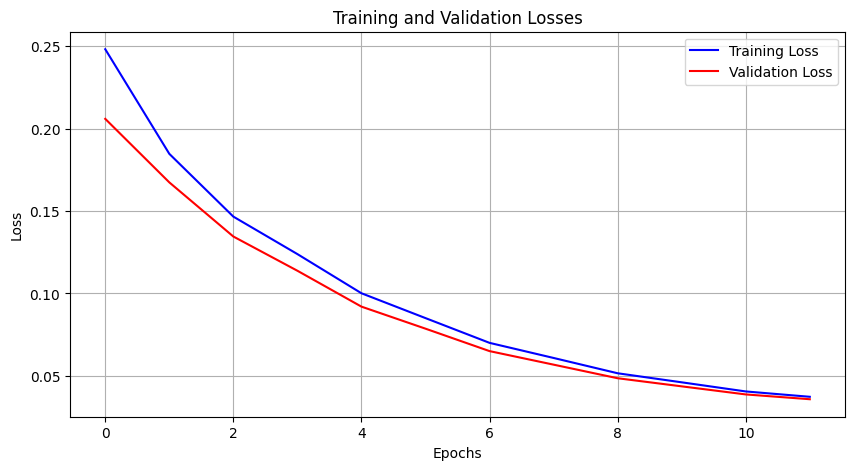

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(valid_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Load The Model

In [ ]:
encoder_arch = (1, 32, 64, 128)
decoder_arch = (128, 64, 32)
out_channels = 1
model = UNet(encoder_arch, decoder_arch, out_channels)
parameters = torch.load("/kaggle/input/unet_params/pytorch/default/1/parameters.pth")
model.load_state_dict(parameters)

## Calculate Generalization Error

In [54]:
test_dataset = CustomDataset(test_df, SR, SIZE, N_FFT, HOP_LENGTH, N_MELS)
test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

model.eval()
criterion = nn.MSELoss()
generalization_error = evaluate_model(model, test_loader, criterion)
print(f"Generalization Error is: {generalization_error}")

Generalization Error is: 0.033732976764440536


In [55]:
test_records = DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=0,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )

In [57]:
 # List to store individual losses
losses = []    
# Disable gradient computation
model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_records):
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_value = loss.cpu().numpy()
        losses.append(loss_value)
    test_df['loss'] = losses

/tmp/ipykernel_30/3077869250.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['loss'] = losses


In [58]:
test_df.head()

,input_file_name,output_file_name,digit,speaker_id,loss
6500,7_14_35_noisy.wav,7_14_35.wav,7,14,0.034747463
6501,0_14_48_noisy.wav,0_14_48.wav,0,14,0.030534301
6502,3_14_28_noisy.wav,3_14_28.wav,3,14,0.029155623
6503,7_14_9_noisy.wav,7_14_9.wav,7,14,0.031404283
6504,1_14_12_noisy.wav,1_14_12.wav,1,14,0.029371928


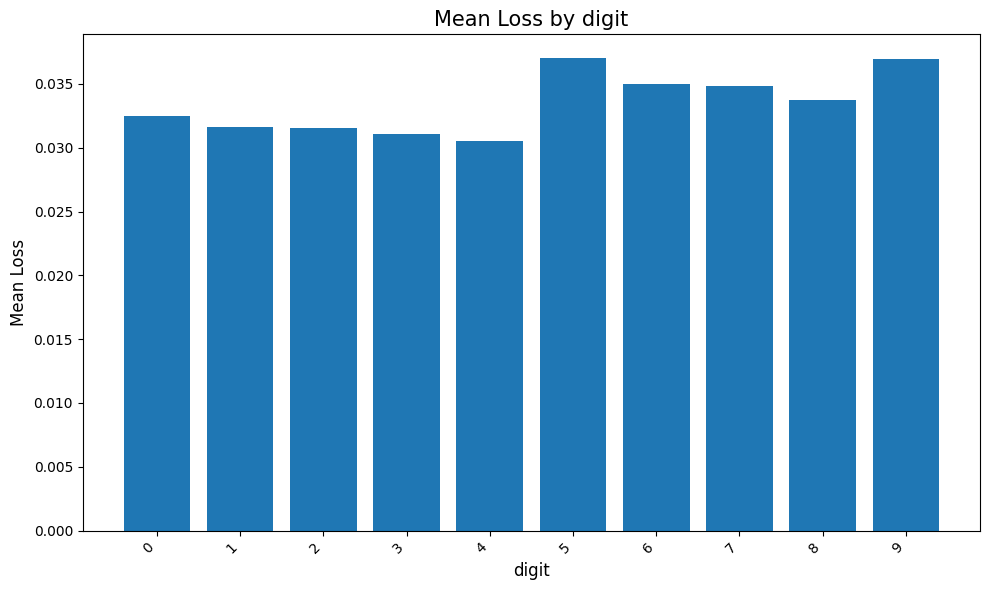

In [60]:
grouped_losses = test_df.groupby("digit")['loss'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(grouped_losses["digit"], grouped_losses['loss'])
ax.set_title(f'Mean Loss by digit', fontsize=15)
ax.set_xlabel("digit", fontsize=12)
ax.set_ylabel('Mean Loss', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

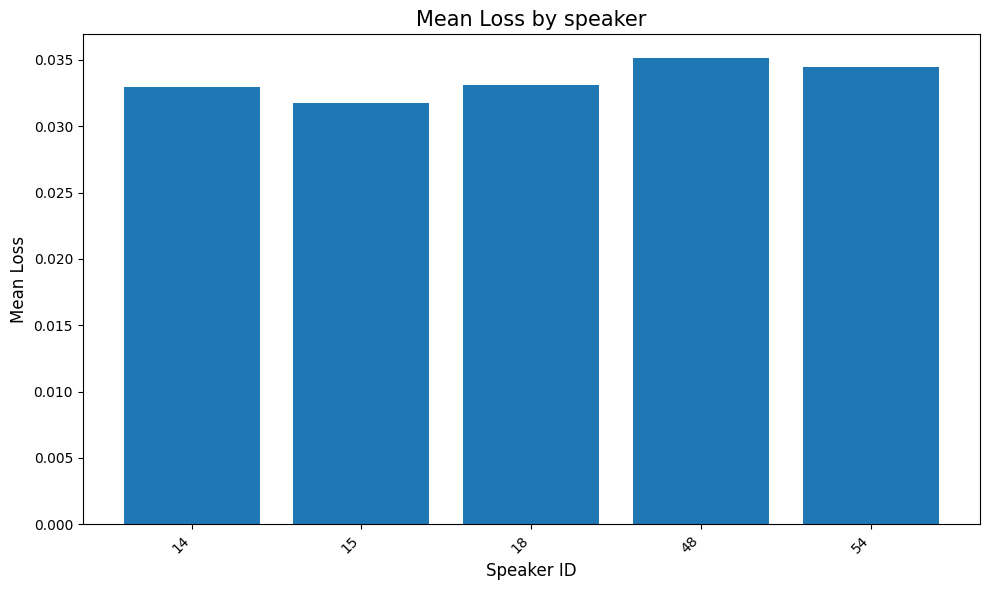

In [61]:
grouped_losses = test_df.groupby("speaker_id")['loss'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(grouped_losses["speaker_id"], grouped_losses['loss'])
ax.set_title(f'Mean Loss by speaker', fontsize=15)
ax.set_xlabel("Speaker ID", fontsize=12)
ax.set_ylabel('Mean Loss', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()